In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage import data, color, io
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage.feature import canny
from skimage.draw import circle_perimeter, ellipse_perimeter
from skimage.util import img_as_ubyte
from skimage.color import rgb2hsv, rgb2gray

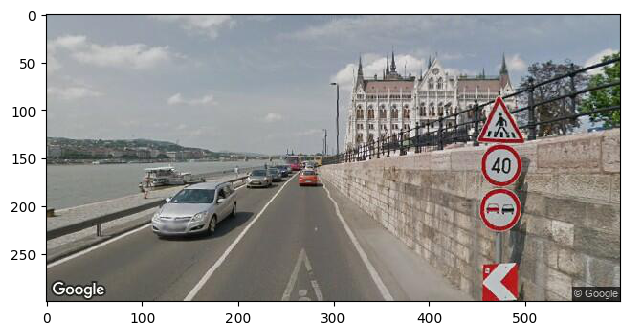

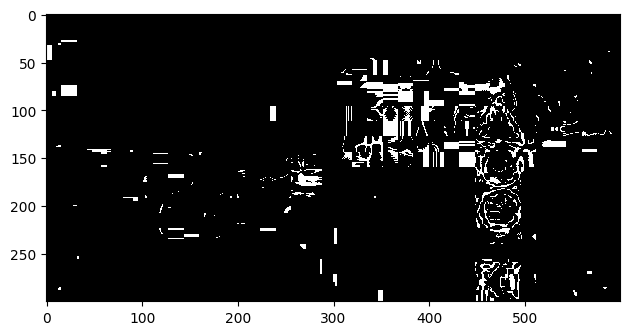

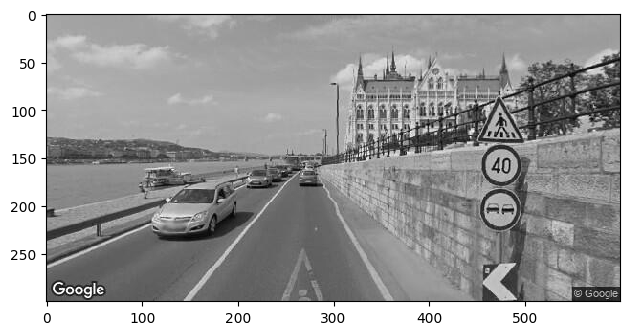

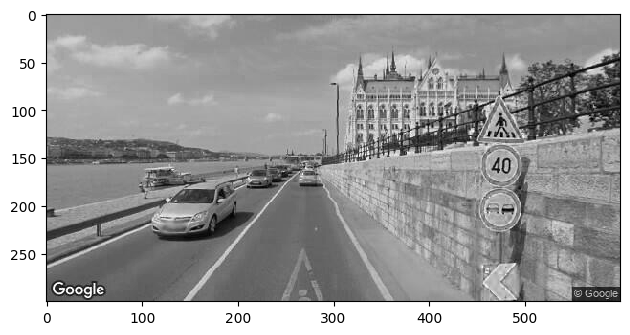

[475 517 475 436 186 474 494 396 401 531 475 367 443 427 475 473 474 474
 469 515 470 489 521 436 474 472 475 476 473 423 163 530 535 476 339 377
 476 472 430 478 377 475 398 501 474 353 388 479 396 474 475 455 400 465
 518 369 503 453 344 465]
######


In [3]:
# Load picture and detect edges
image_rgb = io.imread(r"C:\Users\loren\Documents\AI_BME\traffic\training_images\7.jpg")
image_hsv = rgb2hsv(image_rgb)
io.imshow(image_rgb)
io.show()

hue_img = image_hsv[:, :, 0]
hue_threshold = 0.05
binary_img = hue_img < hue_threshold
io.imshow(binary_img)
io.show()
image_gray = rgb2gray(image_rgb)


Y = (
    0.95 * image_rgb[:, :, 0] + 0.025 * image_rgb[:, :, 1] + 0.025 * image_rgb[:, :, 2]
) / 256
io.imshow(image_gray)
io.show()
io.imshow(Y)
io.show()

edges = canny(Y)


# Detect multiple radii
hough_radii = np.arange(10, 30, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, num_peaks=3)
print(cx)
print("######")

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image_gray)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    # image[circy, circx] = (220, 20, 20)


# detect ellipse
result = hough_ellipse(edges, threshold=8, max_size=90, min_size=10)
result.tolist()
rr, cc = ellipse_perimeter(result[1:4])
image[rr, cc] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

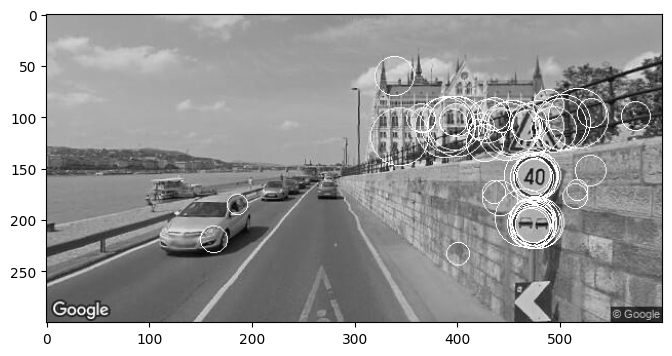

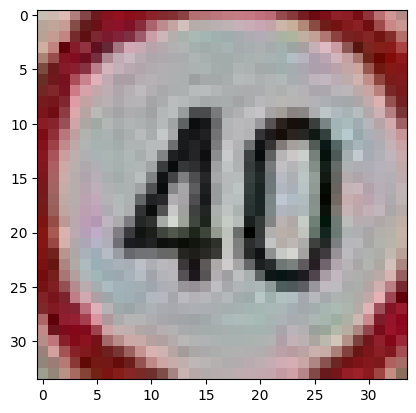

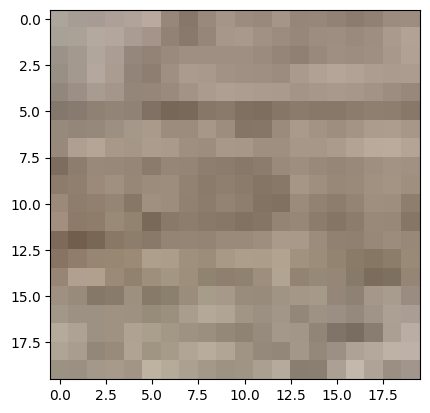

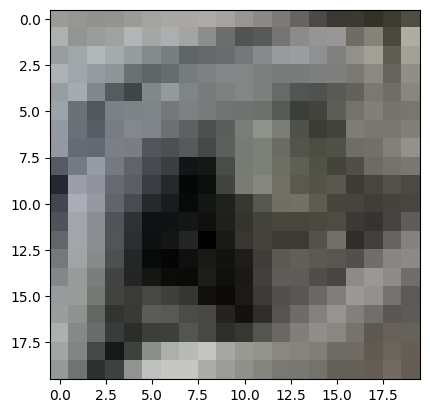

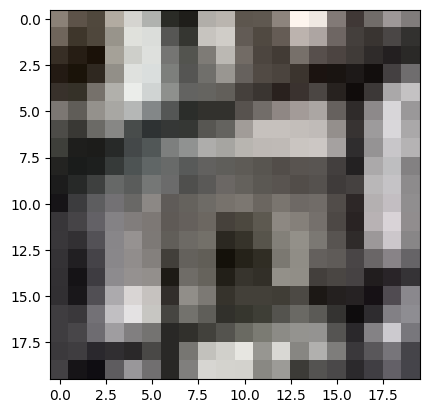

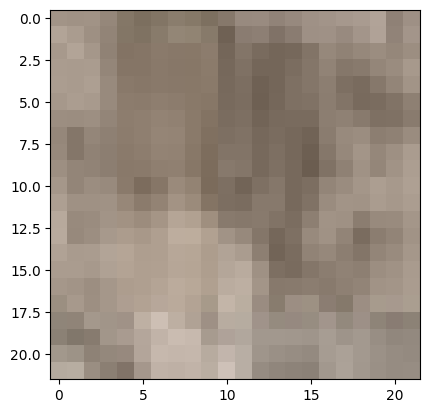

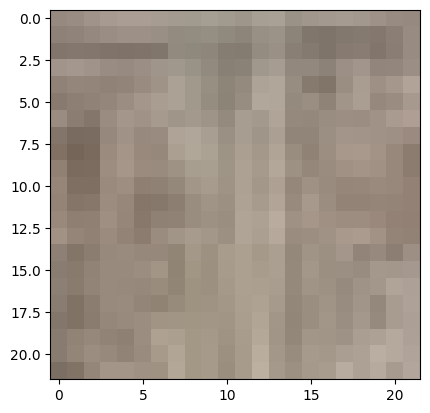

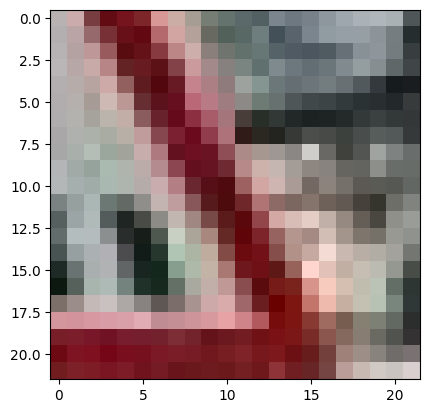

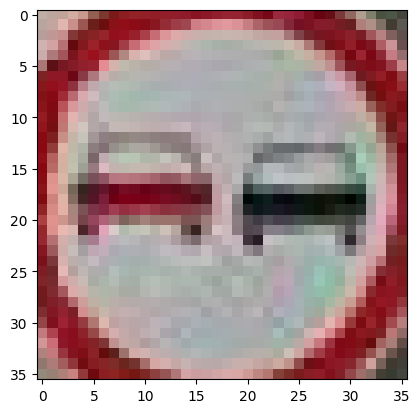

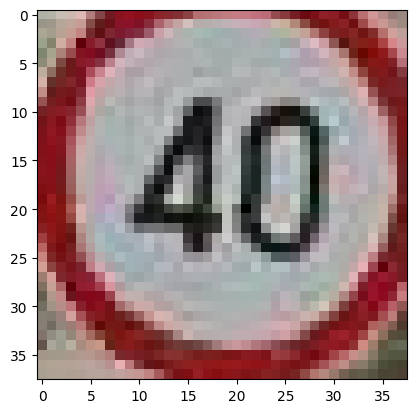

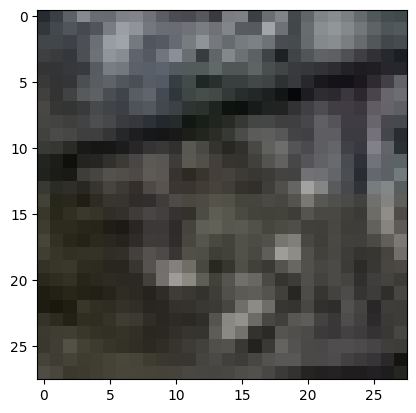

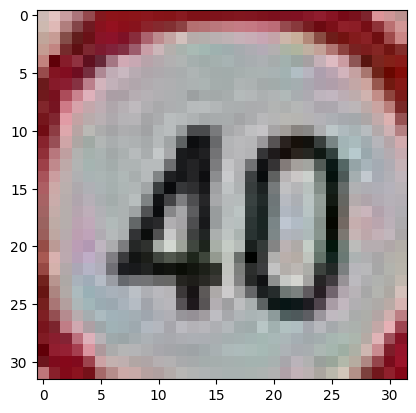

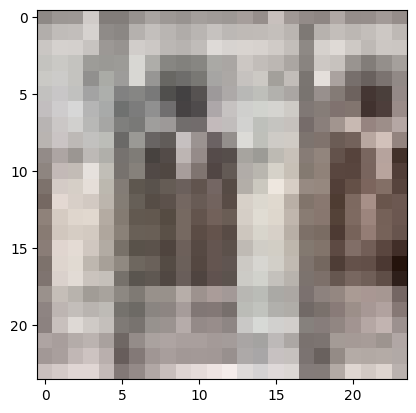

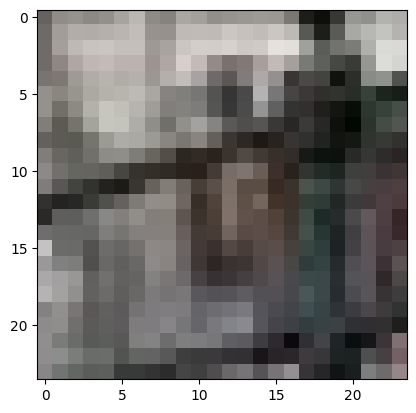

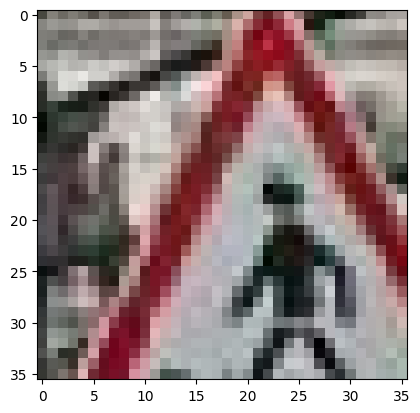

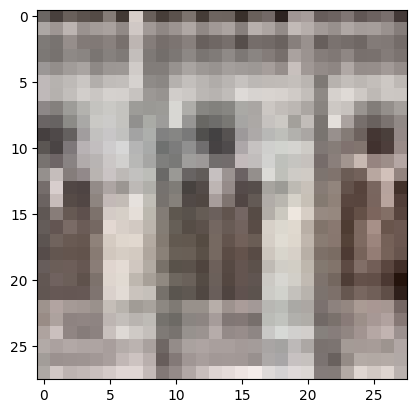

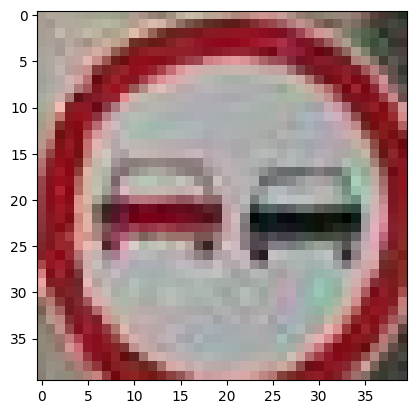

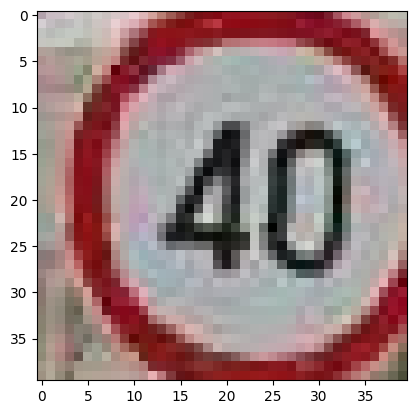

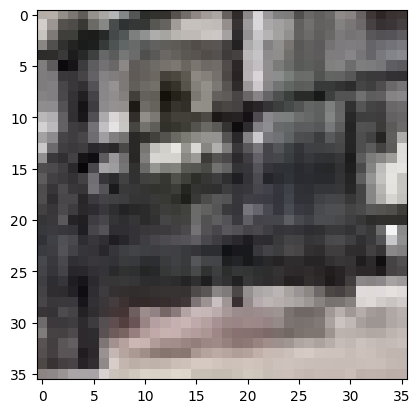

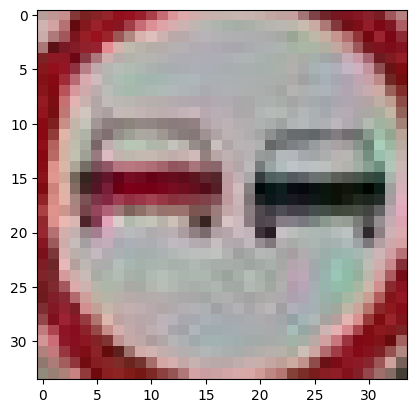

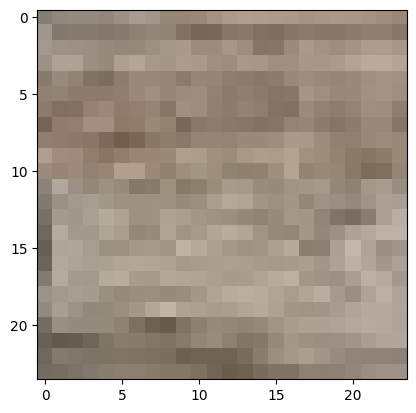

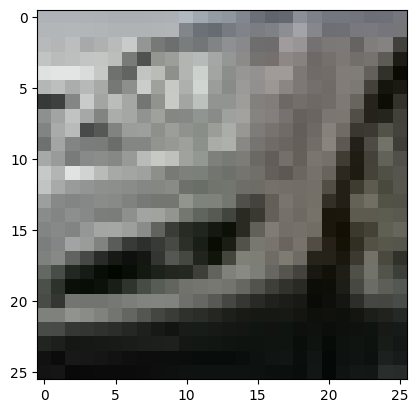

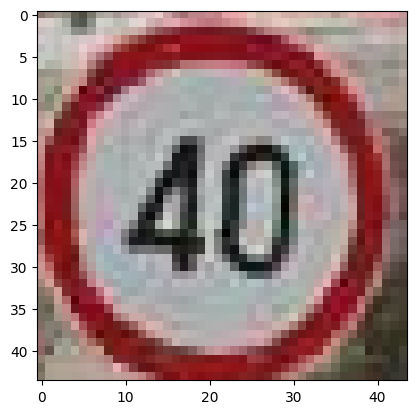

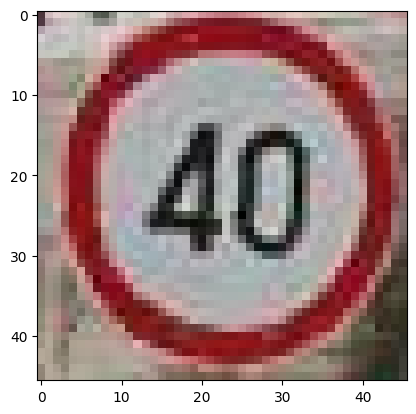

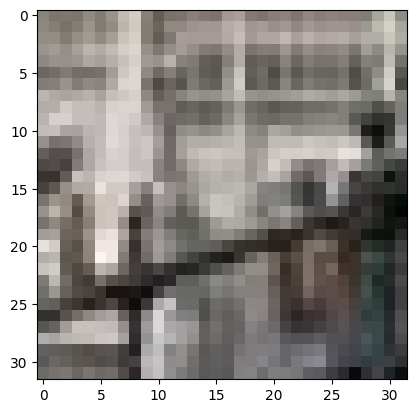

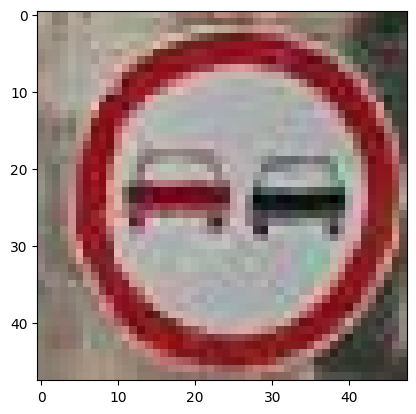

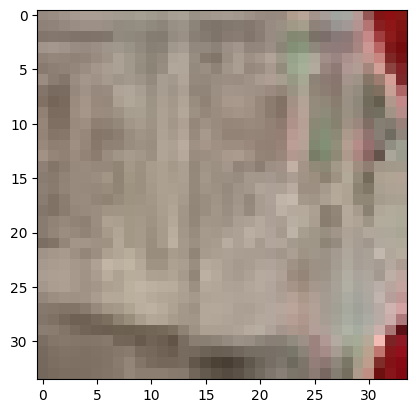

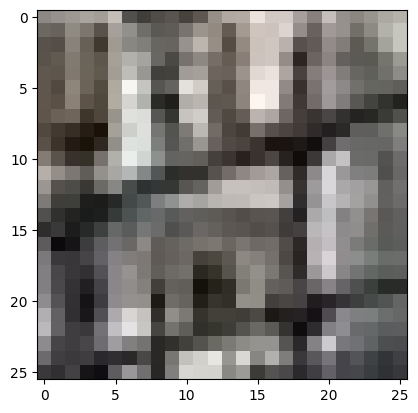

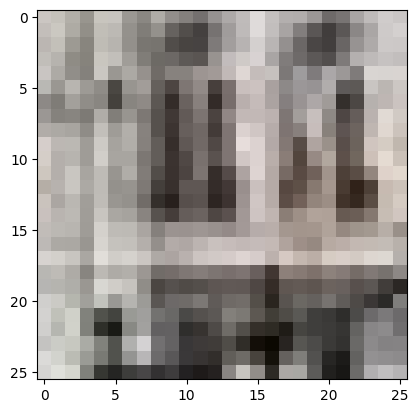

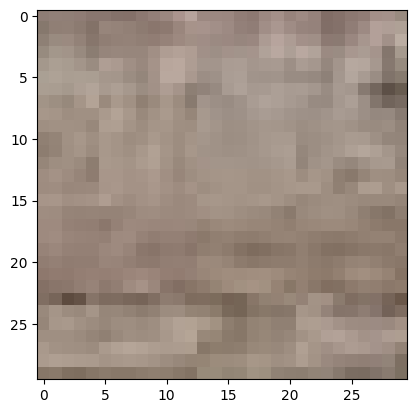

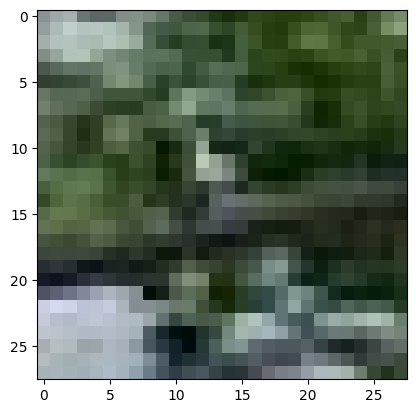

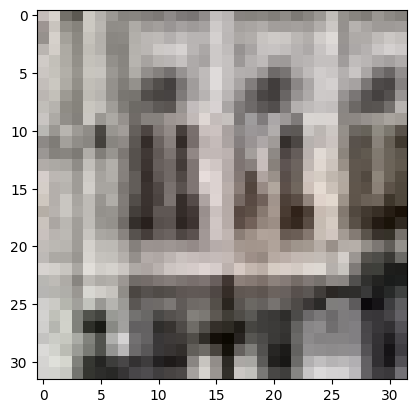

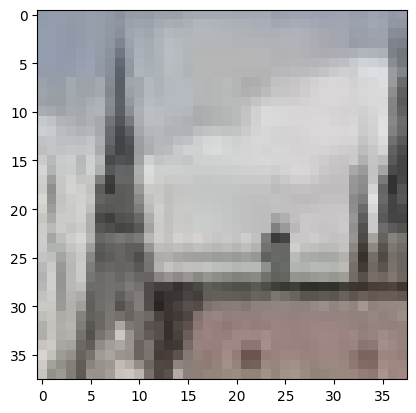

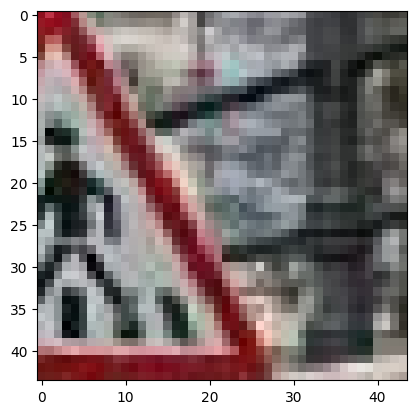

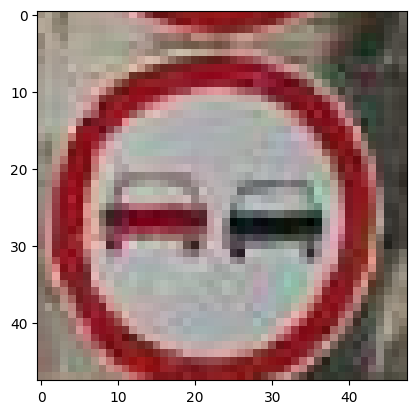

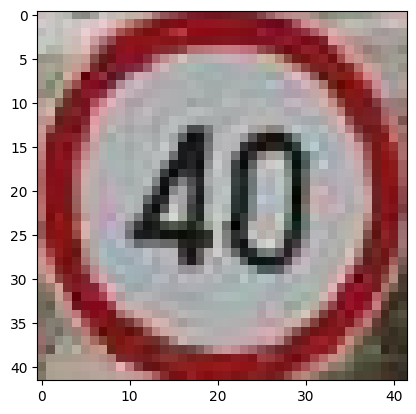

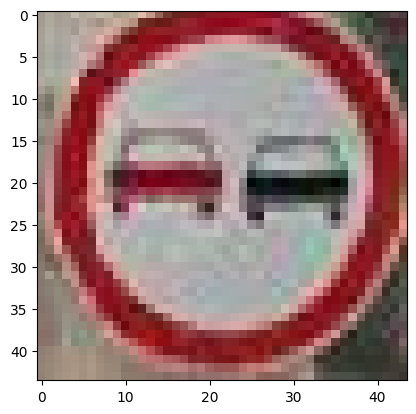

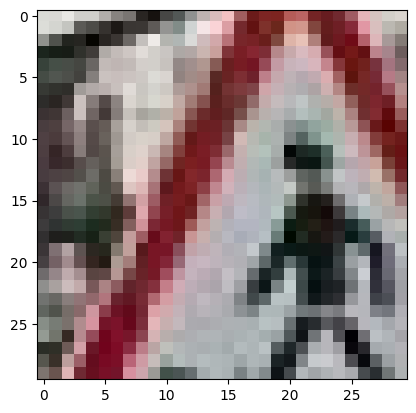

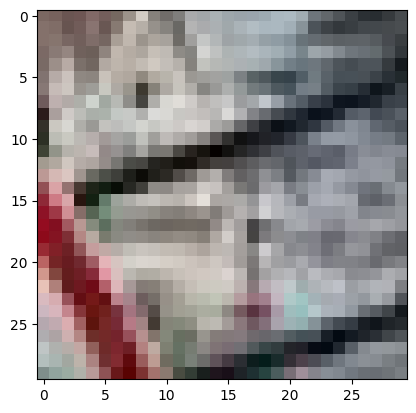

KeyboardInterrupt: ignored

In [11]:


for center_y, center_x, radius in zip(cy, cx, radii):
  small=image_rgb[center_y-radius:center_y+radius,center_x-radius:center_x+radius]
  plt.imshow(small)
  plt.show()

